Link for blogpost : https://medium.com/@patelsaadn/rnns-for-algorithmic-trading-simplified-theory-and-python-implementation-6292055ba770

In [7]:
#Importing Python Modules/Packages

import os
from pathlib import Path
from math import *
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import seaborn as sns

from scipy.stats import spearmanr, norm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import scipy


import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [10]:
# results_path = Path('/content/drive/MyDrive/HFT/data/results', 'univariate_time_series')


In [11]:
sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('/content/drive/MyDrive/HFT/data/results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

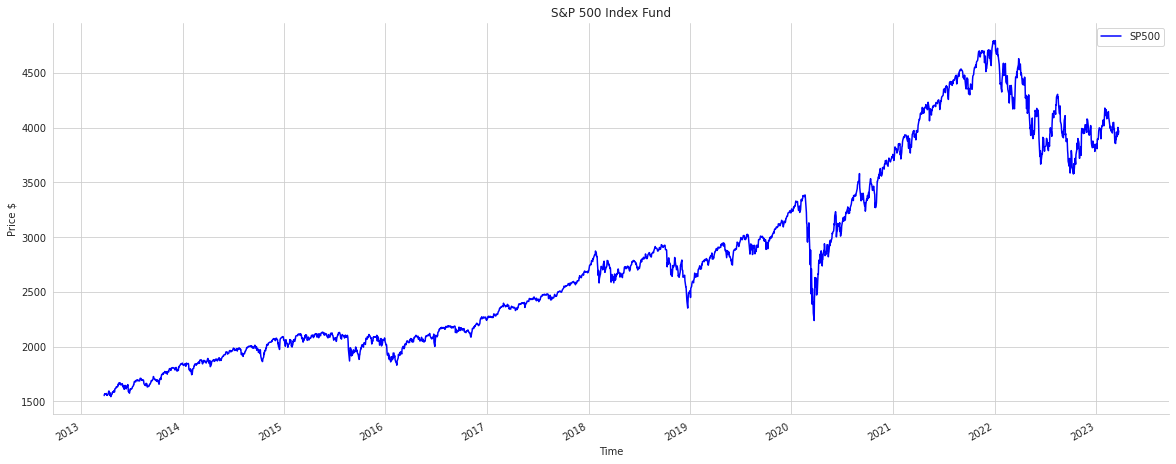

In [12]:
snp500 = web.DataReader('SP500', 'fred', start='2013', end='2024').dropna()
ax = snp500.plot(title='S&P 500 Index Fund', figsize=(20, 8), c='b')
ax.set_xlabel('Time')
ax.set_ylabel('Price $')
sns.despine()

In [13]:
snp500.head()

scaler = MinMaxScaler() # The default scale for the MinMaxScaler is to rescale variables into the range [0,1]
sp500_scaled = pd.Series(scaler.fit_transform(snp500).squeeze(), index=snp500.index) # transform(X) will Scale features of X according to feature_range.

sp500_scaled.describe()


count    2519.000000
mean        0.386143
std         0.267904
min         0.000000
25%         0.161892
50%         0.340853
75%         0.567245
max         1.000000
dtype: float64

In [14]:
sp500_scaled.describe()

count    2519.000000
mean        0.386143
std         0.267904
min         0.000000
25%         0.161892
50%         0.340853
75%         0.567245
max         1.000000
dtype: float64

In [15]:
sp500_scaled.shape

(2519,)

In [16]:
def data_for_rnn(data, window_size):
    n = len(data)
    y = data[window_size:]
    print("previous data shape", data.shape)
    data = data.values.reshape(-1, 1) # make 2D
    print("updated data shape", data.shape)
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    print(X.shape, y.shape)
    return pd.DataFrame(X, index=y.index), y

In [17]:
window_size = 50
X, y = data_for_rnn(sp500_scaled, window_size=window_size)

previous data shape (2519,)
updated data shape (2519, 1)
(2469, 50) (2469,)


In [18]:
sp500_scaled.head(10)

DATE
2013-03-25    0.003097
2013-03-26    0.006808
2013-03-27    0.006525
2013-03-28    0.008473
2013-04-01    0.006317
2013-04-02    0.008799
2013-04-03    0.003711
2013-04-04    0.005644
2013-04-05    0.003585
2013-04-08    0.006593
dtype: float64

In [19]:
X

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
DATE,,,,,,,,,,,,,,,,,,,,,
2013-06-05,0.003097,0.006808,0.006525,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,...,0.039186,0.034944,0.033457,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580
2013-06-06,0.006808,0.006525,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,...,0.034944,0.033457,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673
2013-06-07,0.006525,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,0.014169,...,0.033457,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673,0.024870
2013-06-10,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,0.014169,0.015902,...,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673,0.024870,0.031266
2013-06-11,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,0.014169,0.015902,0.014513,...,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673,0.024870,0.031266,0.031091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-20,0.696321,0.723043,0.722125,0.730469,0.745941,0.750107,0.754998,0.752503,0.733421,0.724202,...,0.770153,0.751090,0.752823,0.730183,0.712754,0.710963,0.730481,0.722076,0.743074,0.729667
2023-03-21,0.723043,0.722125,0.730469,0.745941,0.750107,0.754998,0.752503,0.733421,0.724202,0.746862,...,0.751090,0.752823,0.730183,0.712754,0.710963,0.730481,0.722076,0.743074,0.729667,0.740398
2023-03-22,0.722125,0.730469,0.745941,0.750107,0.754998,0.752503,0.733421,0.724202,0.746862,0.761363,...,0.752823,0.730183,0.712754,0.710963,0.730481,0.722076,0.743074,0.729667,0.740398,0.756159


In [20]:
y.head()

DATE
2013-06-05    0.020673
2013-06-06    0.024870
2013-06-07    0.031266
2013-06-10    0.031091
2013-06-11    0.025967
dtype: float64

In [21]:
X[:'2018']

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
DATE,,,,,,,,,,,,,,,,,,,,,
2013-06-05,0.003097,0.006808,0.006525,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,...,0.039186,0.034944,0.033457,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580
2013-06-06,0.006808,0.006525,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,...,0.034944,0.033457,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673
2013-06-07,0.006525,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,0.014169,...,0.033457,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673,0.024870
2013-06-10,0.008473,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,0.014169,0.015902,...,0.033177,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673,0.024870,0.031266
2013-06-11,0.006317,0.008799,0.003711,0.005644,0.003585,0.006593,0.008295,0.014169,0.015902,0.014513,...,0.036391,0.032796,0.034655,0.027383,0.030357,0.027580,0.020673,0.024870,0.031266,0.031091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.364602,0.376510,0.371490,0.389656,0.389438,0.377017,0.376709,0.373053,0.368387,0.342399,...,0.336752,0.336463,0.340853,0.340690,0.325148,0.308555,0.308622,0.296579,0.284431,0.268824
2018-12-26,0.376510,0.371490,0.389656,0.389438,0.377017,0.376709,0.373053,0.368387,0.342399,0.357597,...,0.336463,0.340853,0.340690,0.325148,0.308555,0.308622,0.296579,0.284431,0.268824,0.248695
2018-12-27,0.371490,0.389656,0.389438,0.377017,0.376709,0.373053,0.368387,0.342399,0.357597,0.343194,...,0.340853,0.340690,0.325148,0.308555,0.308622,0.296579,0.284431,0.268824,0.248695,0.284517


In [22]:
y[:'2018']

DATE
2013-06-05    0.020673
2013-06-06    0.024870
2013-06-07    0.031266
2013-06-10    0.031091
2013-06-11    0.025967
                ...   
2018-12-24    0.248695
2018-12-26    0.284517
2018-12-27    0.291009
2018-12-28    0.290060
2018-12-31    0.296545
Length: 1404, dtype: float64

In [23]:
X_train = X[:'2021'].values.reshape(-1, window_size, 1)
y_train = y[:'2021']

# keep the last year for testing
X_test = X['2022'].values.reshape(-1, window_size, 1)
y_test = y['2022']

<ipython-input-23-10130eff6def>:5: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  X_test = X['2022'].values.reshape(-1, window_size, 1)


In [24]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2161, 50, 1) (2161,) (251, 50, 1) (251,)


In [25]:
n_obs, window_size, n_features = X_train.shape

In [25]:
# Define a Sequential model
rnn = Sequential([
    # Add an LSTM layer with 10 units or neurons, input_shape of (window_size, n_features), and name 'LSTM'
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    # Add a Dense layer with 1 neuron and name 'Output'
    Dense(1, name='Output')
])

# Print the summary of the model
print(rnn.summary())

# Create an RMSprop optimizer with a learning rate of 0.001, rho of 0.9, and epsilon of 1e-08
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

# Compile the model with a mean squared error loss function and the RMSprop optimizer created above
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

# Define the path to save the model results
results_path = Path('/content/drive/MyDrive/HFT/data/results', 'univariate_time_series') # Tested on colab, so created a repo in my GDrive

# Define the path to save the best performing weights of the RNN model
rnn_path = (results_path / 'rnn.h5').as_posix()

# Create a ModelCheckpoint callback that saves the weights of the RNN model to rnn_path if validation loss improves
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

# Create an EarlyStopping callback that stops training if validation loss does not improve for 40 epochs, and restore the best performing weights
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)

In [31]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=200,
                        batch_size=10,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/200
212/217 [============================>.] - ETA: 0s - loss: 0.0039
Epoch 1: val_loss improved from inf to 0.00194, saving model to /content/drive/MyDrive/HFT/data/results/univariate_time_series/rnn.h5
217/217 [==============================] - 11s 15ms/step - loss: 0.0039 - val_loss: 0.0019
Epoch 2/200
217/217 [==============================] - ETA: 0s - loss: 2.9483e-04
Epoch 2: val_loss improved from 0.00194 to 0.00100, saving model to /content/drive/MyDrive/HFT/data/results/univariate_time_series/rnn.h5
217/217 [==============================] - 1s 6ms/step - loss: 2.9483e-04 - val_loss: 0.0010
Epoch 3/200
213/217 [============================>.] - ETA: 0s - loss: 2.7101e-04
Epoch 3: val_loss did not improve from 0.00100
217/217 [==============================] - 1s 5ms/step - loss: 2.6828e-04 - val_loss: 0.0021
Epoch 4/200
217/217 [==============================] - ETA: 0s - loss: 2.5109e-04
Epoch 4: val_loss improved from 0.00100 to 0.00084, saving model to /content/dri

In [32]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0096 | Test RMSE: 0.0191


In [33]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

# Spearman rank correlation is a non-parametric test that is used to measure the degree of association between two variables.

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic} | Test IC: {test_ic}')


8/8 [==============================] - 0s 3ms/step
Train IC: 0.998533299020294 | Test IC: 0.9721980648833239


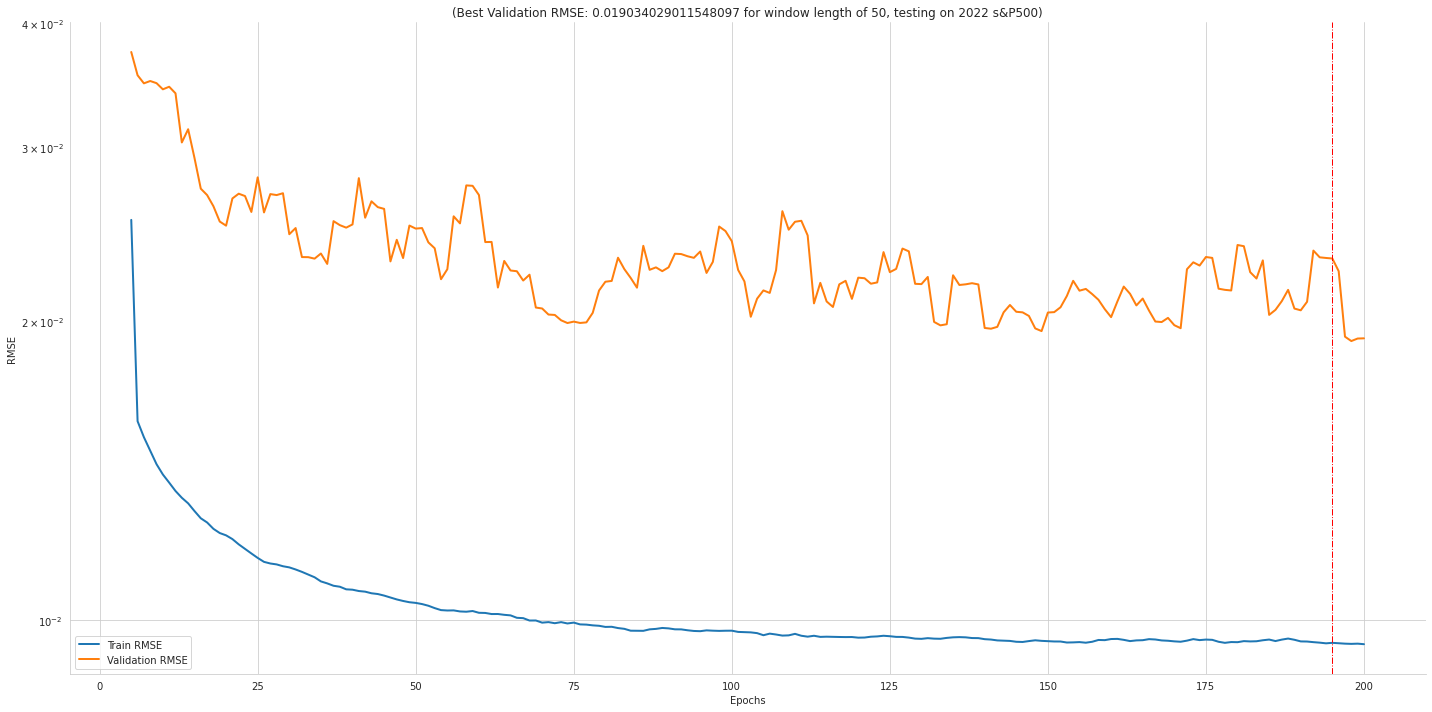

In [34]:
fig, ax = plt.subplots(figsize=(20, 10))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'(Best Validation RMSE: {best_rmse} for window length of 50, testing on 2022 s&P500)'
loss_history.columns=['Train RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='-.', lw=1, c='r')
ax.set_xlabel('Epochs')
ax.set_ylabel('RMSE')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [35]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse} | Test RMSE: {test_rmse}')

Train RMSE: 31.162661786164964 | Test RMSE: 62.09228035778334


In [36]:
snp500['Train Predictions'] = train_predict
snp500['Test Predictions'] = test_predict
snp500 = snp500.join(train_predict.to_frame('predictions').assign(data='Train') .append(test_predict.to_frame('predictions').assign(data='Test')))

<ipython-input-36-f9c4fb332678>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  snp500 = snp500.join(train_predict.to_frame('predictions').assign(data='Train') .append(test_predict.to_frame('predictions').assign(data='Test')))


Text(0.5, 1.0, 'Predictions')

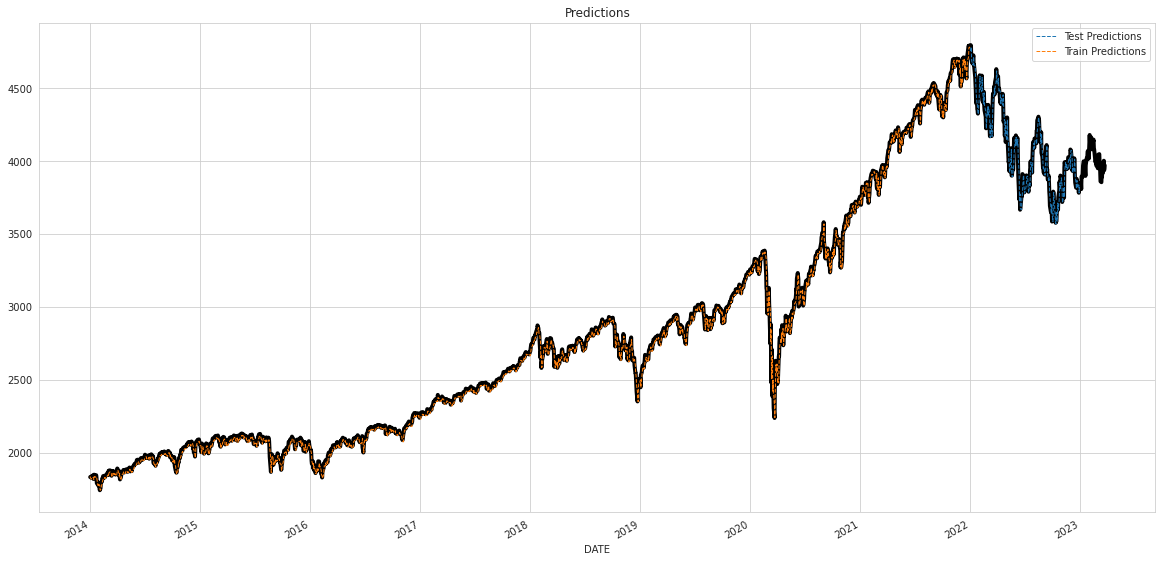

In [50]:
# fig=plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(20, 10))

# ax1 = plt.subplot(221)

snp500.loc['2014':, 'SP500'].plot(lw=4, ax=ax, c='k')
snp500.loc['2014':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax, ls='--')
ax.set_title('Predictions')

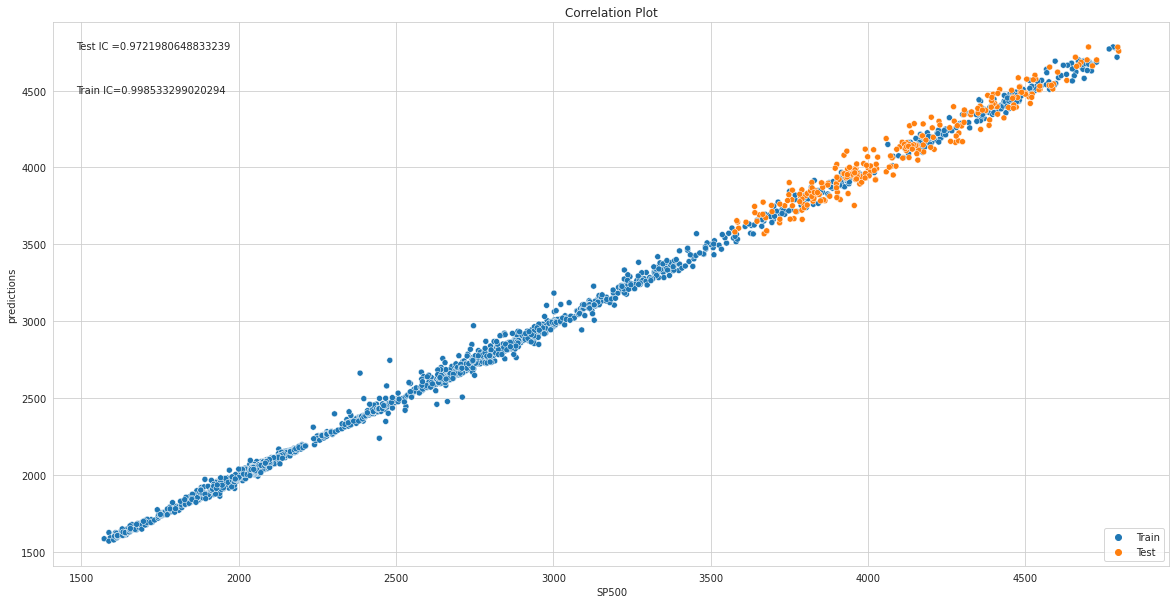

In [53]:
fig, ax3 = plt.subplots(figsize=(20, 10))
sns.scatterplot(x='SP500', y='predictions', data=snp500, hue='data', ax=ax3)
ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic}', transform=ax3.transAxes)
ax3.text(x=.02, y=.87, s=f'Train IC={train_ic}', transform=ax3.transAxes)
ax3.set_title('Correlation Plot')
ax3.legend(loc='lower right')

<ipython-input-56-a4b0ee4c9093>:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax4 = plt.subplot(sharex = ax2, sharey=ax2)
<ipython-input-56-a4b0ee4c9093>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
<ipython-input-56-a4b0ee4c9093>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function 

Text(0.03, 0.92, 'Test RMSE =62.09228035778334')

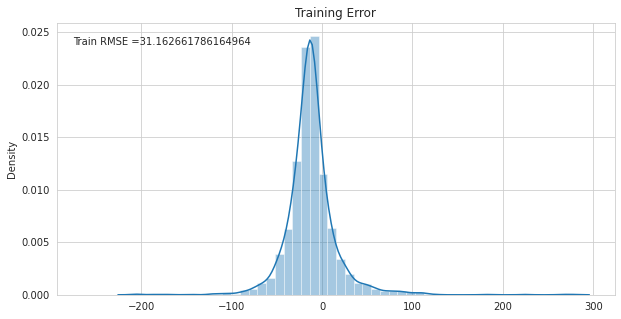

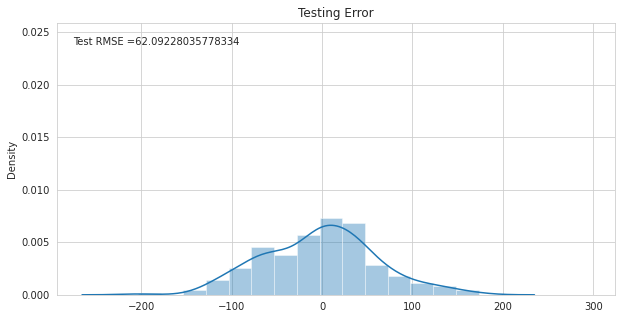

In [56]:
fig, ax2 = plt.subplots(figsize=(10, 5))
fig, ax4 = plt.subplots(figsize=(10, 5))

ax4 = plt.subplot(sharex = ax2, sharey=ax2)
sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
ax2.set_title('Training Error')
ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse}', transform=ax2.transAxes)
sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
ax4.set_title('Testing Error')
ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse}', transform=ax4.transAxes)